![image.png](https://i.imgur.com/a3uAqnb.png)

# Neural Network Regression for California Housing Prices - Homework Assignment

In this homework, you will implement a **Neural Network for regression** to predict the median value of California houses. This project will help you understand the fundamentals of neural networks applied to regression tasks.

## 📌 Project Overview
- **Task**: Predict median house values in California
- **Architecture**: Multi-layer Perceptron (MLP) for regression
- **Dataset**: California Housing dataset (provided)
- **Goal**: Build an accurate regression model using PyTorch

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand neural networks for regression problems
- Learn data preprocessing and feature engineering
- Implement a custom neural network architecture
- Practice training, validation, and evaluation
- Learn about regression metrics and model performance


## 1️⃣ Initial Setup and Library Installation

**Task**: Set up the environment and install necessary libraries.

In [1]:
from IPython.display import clear_output

In [2]:
# Incase you run this notebook outside colab (where the libraries aren't already pre-installed)

# %pip install torch
# %pip install matplotlib
# %pip install scikit-learn

clear_output()


## 2️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up configuration parameters.

**Requirements**:
- Import PyTorch and neural network modules
- Import data processing libraries (pandas, sklearn)
- Import visualization libraries
- Set random seeds for reproducibility
- Configure hyperparameters with reasonable values

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

BATCH_SIZE = 64          # Batch size for training
LEARNING_RATE = 0.001    # Learning rate for optimizer
NUM_EPOCHS = 100         # Number of training epochs
HIDDEN_SIZE = 128        # Size of hidden layers
NUM_HIDDEN_LAYERS = 3    # Number of hidden layers
VALIDATION_SPLIT = 0.3   # Validation split ratio

Using device: cuda


## 3️⃣ Data Loading and Exploration

**Task**: Load the California housing dataset and explore its structure.

**Requirements**:
- Download and load the dataset
- Display basic information about the data
- Check for missing values
- Understand the features and target variable

In [5]:
# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████████| 400k/400k [00:02<00:00, 146kB/s]

Extracting files...
Path to dataset files: /home/ali/.cache/kagglehub/datasets/camnugent/california-housing-prices/versions/1


In [6]:
# List files in the dataset directory
print("Files in dataset directory:")
for file in os.listdir(path):
    print(file)

Files in dataset directory:
housing.csv


In [7]:
# Load the dataset
california_data = pd.read_csv(os.path.join(path, 'housing.csv'))
print(f"Dataset shape: {california_data.shape}")
print(f"Columns: {list(california_data.columns)}")

Dataset shape: (20640, 10)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [8]:
california_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
print("\nMissing values:")
print(california_data.isnull().sum())
print("\nBasic statistics:")
california_data.describe()


Missing values:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Basic statistics:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000



## 4️⃣ Data Preprocessing and Feature Engineering

**Task**: Clean and prepare the data for neural network training.

**Requirements**:
- Handle missing values if any
- Encode categorical variables
- Scale numerical features
- Split features and target
- Create train/validation/test splits

In [10]:
california_data = california_data.copy()

In [11]:
# Handle missing values (fill with median for numerical columns)
california_data['total_bedrooms'].fillna(california_data['total_bedrooms'].median(), inplace=True)

# Feature engineering - create new features
california_data['rooms_per_household'] = california_data['total_rooms'] / california_data['households']
california_data['bedrooms_per_room'] = california_data['total_bedrooms'] / california_data['total_rooms']
california_data['population_per_household'] = california_data['population'] / california_data['households']

# Separate features from target
X = california_data.drop('median_house_value', axis=1)
y = california_data['median_house_value']

# Encode the categorical ocean_proximity column
label_encoder = LabelEncoder()
X['ocean_proximity'] = label_encoder.fit_transform(X['ocean_proximity'])

# Scale the features for better neural network performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to numpy arrays
X_scaled = np.array(X_scaled, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Split the data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=VALIDATION_SPLIT, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

Training set size: 11558
Validation set size: 4954
Test set size: 4128
Number of features: 12


/tmp/ipykernel_10231/1636970119.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  california_data['total_bedrooms'].fillna(california_data['total_bedrooms'].median(), inplace=True)


## 5️⃣ Neural Network Architecture

**Task**: Design and implement a neural network for regression.

**Requirements**:
- Create a multi-layer perceptron (MLP)
- Use appropriate activation functions
- Ensure proper input/output dimensions
- Use suitable architecture for regression

In [12]:
class HousePricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers):
        super(HousePricePredictor, self).__init__()
        
        # Input layer
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        
        # Output layer (single neuron for regression)
        layers.append(nn.Linear(hidden_size, 1))
        
        # Create sequential model
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        # Forward pass through the network
        return self.network(x)

# Initialize the model
input_size = X_train.shape[1]
model = HousePricePredictor(input_size, HIDDEN_SIZE, NUM_HIDDEN_LAYERS).to(device)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

# Test the model with a sample input
sample_input = torch.randn(1, input_size).to(device)
sample_output = model(sample_input)
print(f"\nSample input shape: {sample_input.shape}")
print(f"Sample output shape: {sample_output.shape}")
print(f"Sample output value: {sample_output.item():.2f}")

Model architecture:
HousePricePredictor(
  (network): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 34817

Sample input shape: torch.Size([1, 12])
Sample output shape: torch.Size([1, 1])
Sample output value: -0.01



## 6️⃣ Loss Function and Optimizer

**Task**: Set up appropriate loss function and optimizer for regression.

**Requirements**:
- Choose suitable loss function for regression
- Initialize optimizer with hyperparameters

In [14]:
# Define loss function for regression
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 7️⃣ Training Loop with Validation

**Task**: Implement a comprehensive training loop with validation.

**Requirements**:
- Train the model for specified epochs
- Track training and validation losses
- Save the best model based on validation performance
- Display training progress

In [15]:
# Create DataLoader for batch processing
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize tracking variables
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("Starting training...")

# Training loop
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    # Calculate average losses
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print(f"\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...
Epoch [10/100], Train Loss: 4462657589.7459, Val Loss: 4431622334.3590
Epoch [20/100], Train Loss: 4094270951.2486, Val Loss: 4116170770.0513
Epoch [30/100], Train Loss: 3955284180.1547, Val Loss: 4028988652.3077
Epoch [40/100], Train Loss: 3862727854.6740, Val Loss: 3947429417.0256
Epoch [50/100], Train Loss: 3790106527.1160, Val Loss: 3922485915.8974
Epoch [60/100], Train Loss: 3737291601.3260, Val Loss: 3896976543.1795
Epoch [70/100], Train Loss: 3685525739.4917, Val Loss: 3843761453.9487
Epoch [80/100], Train Loss: 3638996950.9834, Val Loss: 3817948059.8974
Epoch [90/100], Train Loss: 3601152637.1713, Val Loss: 3783997011.6923
Epoch [100/100], Train Loss: 3578638870.6298, Val Loss: 3743039778.4615

Training completed!
Best validation loss: 3743039778.4615




## 8️⃣ Model Evaluation and Testing

**Task**: Evaluate the trained model on the test set and calculate regression metrics.

**Requirements**:
- Make predictions on test set
- Calculate multiple regression metrics
- Analyze model performance

In [16]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to eval mode
model.eval()

# Make predictions on test set
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    test_predictions = model(X_test_device).cpu().numpy()

# Convert back to original scale for better interpretation
y_test_np = y_test_tensor.numpy()

# Calculate regression metrics
mse = mean_squared_error(y_test_np, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, test_predictions)
r2 = r2_score(y_test_np, test_predictions)

print("Test Set Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Additional metrics
print(f"\nAdditional Information:")
print(f"Mean actual house value: ${y_test_np.mean():.2f}")
print(f"Mean predicted house value: ${test_predictions.mean():.2f}")
print(f"RMSE as percentage of mean: {(rmse / y_test_np.mean()) * 100:.2f}%")

Test Set Performance:
Mean Squared Error (MSE): 4119556096.00
Root Mean Squared Error (RMSE): 64183.77
Mean Absolute Error (MAE): 43180.81
R² Score: 0.6856

Additional Information:
Mean actual house value: $205500.31
Mean predicted house value: $207239.88
RMSE as percentage of mean: 31.23%


## 9️⃣ Visualization and Analysis

**Task**: Create visualizations to analyze model performance and training progress.

**Requirements**:
- Plot training and validation loss curves
- Analyze residuals

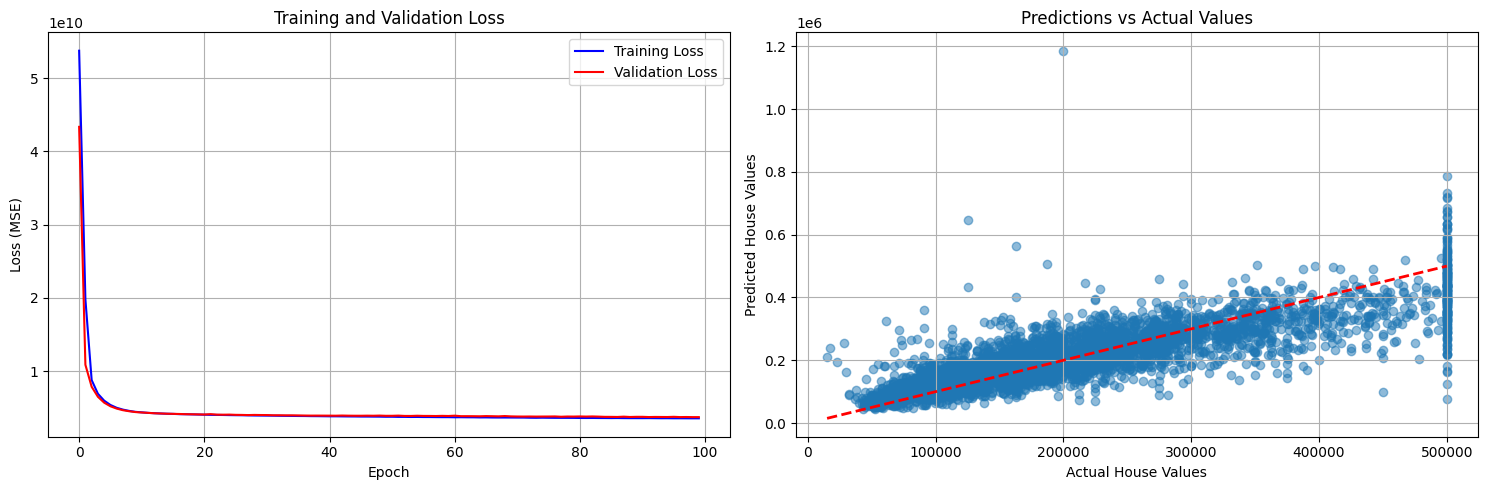


Sample Predictions:
--------------------------------------------------
Actual: $47,700.00 | Predicted: $58,448.28 | Error: $10,748.28
Actual: $45,800.00 | Predicted: $141,839.05 | Error: $96,039.05
Actual: $500,001.00 | Predicted: $390,839.47 | Error: $109,161.53
Actual: $218,600.00 | Predicted: $265,091.53 | Error: $46,491.53
Actual: $278,000.00 | Predicted: $309,016.50 | Error: $31,016.50
Actual: $158,700.00 | Predicted: $190,499.52 | Error: $31,799.52
Actual: $198,200.00 | Predicted: $255,934.86 | Error: $57,734.86
Actual: $157,500.00 | Predicted: $188,334.91 | Error: $30,834.91
Actual: $340,000.00 | Predicted: $288,354.75 | Error: $51,645.25
Actual: $446,600.00 | Predicted: $400,156.97 | Error: $46,443.03


In [18]:
# Plot training and validation loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot predictions vs actual values
plt.subplot(1, 2, 2)
plt.scatter(y_test_np, test_predictions, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', lw=2)
plt.xlabel('Actual House Values')
plt.ylabel('Predicted House Values')
plt.title('Predictions vs Actual Values')
plt.grid(True)

plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions:")
print("-" * 50)
for i in range(10):
    actual = y_test_np[i][0]
    predicted = test_predictions[i][0]
    error = abs(actual - predicted)
    print(f"Actual: ${actual:,.2f} | Predicted: ${predicted:,.2f} | Error: ${error:,.2f}")

## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1. **Implementation Correctness (50%)**
   - Proper neural network architecture
   - Correct data preprocessing and feature engineering(if any)
   - Working training loop with validation
   - Appropriate loss function and optimizer

2. **Model Performance (25%)**
   - Reasonable regression metrics (RMSE, MAE, R²)
   - Convergence during training
   - Generalization to test set

3. **Code Quality (25%)**
   - Clean, readable code with comments
   - Efficient implementation
   - Good coding practices
